<a href="https://colab.research.google.com/github/cakennedy/266-mbti-project/blob/main/models/t5/T5MultiClass.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## T5 References

https://huggingface.co/docs/transformers/model_doc/t5

https://arxiv.org/pdf/1910.10683.pdf

https://colab.research.google.com/github/patil-suraj/exploring-T5/blob/master/t5_fine_tuning.ipynb

https://towardsdatascience.com/data-to-text-generation-with-t5-building-a-simple-yet-advanced-nlg-model-b5cce5a6df45

https://colab.research.google.com/github/datasci-w266/2022-fall-main/blob/master/materials/lesson_notebooks/lesson_6_Machine_Translation.ipynb

http://seekinginference.com/applied_nlp/t5-class.html
http://seekinginference.com/NLP/T5_classification

https://huggingface.co/docs/transformers/perplexity




#Initial Setup 

In this notebook 
a ) I am using data from GCS, from courtney which is cleaned for age and other additional columns , 
b) I am also removing AGE from the model and lower string transformations
c) cleaning up the notebook for only model as of now

In [1]:
# Google collab premium utilities status check
# GPU
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)

print( '\n')

# RAM
from psutil import virtual_memory
ram_gb = virtual_memory().total / 1e9
print('Your runtime has {:.1f} gigabytes of available RAM\n'.format(ram_gb))

if ram_gb < 20:
  print('Not using a high-RAM runtime')
else:
  print('You are using a high-RAM runtime!')

Wed Jan 18 18:58:15 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  A100-SXM4-40GB      Off  | 00000000:00:04.0 Off |                    0 |
| N/A   31C    P0    42W / 400W |      0MiB / 40536MiB |      0%      Default |
|                               |                      |             Disabled |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [2]:
# imports
import sys
import csv
from enum import Enum

#import unidecode 
#import unicodedata
import pandas as pd
import io
from io import BytesIO
import matplotlib.pyplot as plt
import altair as alt
import numpy as np
import textwrap
import re
import time
import random
import datetime

In [3]:
!pip install -q sentencepiece
!pip install -q transformers
!pip install -q optuna

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 55.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.8/5.8 MB 78.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 182.4/182.4 KB 20.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.6/7.6 MB 94.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 365.3/365.3 KB 24.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 210.6/210.6 KB 23.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.7/78.7 KB 10.0 MB/s eta 0:00:00


In [4]:

import os, re
import time
import numpy as np
import pandas as pd

import io
from io import BytesIO
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.cuda.amp import autocast, GradScaler
from torch.utils.data import TensorDataset, random_split, DataLoader, RandomSampler
from transformers import T5Tokenizer, T5ForConditionalGeneration
from transformers import AdamW, get_linear_schedule_with_warmup

from sklearn import metrics
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, classification_report
from sklearn.metrics import f1_score,roc_auc_score,roc_curve,recall_score,matthews_corrcoef

import seaborn as sns
import matplotlib.pyplot as plt

import optuna
from optuna.pruners import SuccessiveHalvingPruner
from optuna.samplers import TPESampler



In [5]:
SEED = 15
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)

In [6]:
torch.cuda.amp.autocast(enabled=True)

In [7]:
torch.backends.cudnn.deterministic = True

# tell pytorch to use cuda
device = torch.device("cuda")

In [8]:
#imports and installs for feature engineering
!pip install empath
from empath import Empath
lexicon = Empath()
# Import module
!pip install NRCLex
from nrclex import NRCLex
import nltk
nltk.download('punkt')
import collections
from collections import Counter
import spacy
nlp =spacy.load("en_core_web_sm")

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.6/57.6 KB 6.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for empath: filename=empath-0.89-py3-none-any.whl size=57822 sha256=4e0bd65572b58e291a5ce24a919e3d55d620abd2595403651ed16429fa204194
  Stored in directory: /root/.cache/pip/wheels/2a/e5/c2/fd8dad0a452927c85ecd3c6cbaa4748125246eed73d8303184
Successfully built empath
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 396.4/396.4 KB 26.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for NRCLex: filename=NRCLex-3.0.0-py3-none-any.whl size=43329 sha256=0571defaf6f32d7fc2a41943c54b363a080a7228d26c6469a59381c58dcc67fc
  Stored in directory: /root/.cache/pip/wheels/83/95/c0/42b43fb15eb48e4f5a67cba8915540cb2783591c59c037a9e5
Successfully built N

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


In [9]:
# To work from gcloud, use this:

# Upload Google Cloud service account key to enable authentication ( json file )
# Go to https://console.cloud.google.com/:
# Under the Navigation Menu ( upper left 3 horizontal lines) 
# 1. choose IAM & Admin>
# 2. choose Service Accounts>
# 3. Select a Service Account>
# 4. Under the Actions menu ( 3 dots to the right of the service account )>Manage Keys to create your own json credentials file

from google.colab import files
from google.cloud import storage


def upload_gcloud_credentials():
    uploaded = files.upload()


def config_GCloud():
    #Load Google Cloud storage client using service key
    storage_client = storage.Client.from_service_account_json('pacific-castle-360400-a3ca89f64de6.json')
    #Print buckets available
    for bucket in storage_client.list_buckets():
        print(bucket)

    #Assign bucket name being used
    gcloud_bucket_name = '266csffile'

    #Get bucket
    gcloud_bucket = storage_client.get_bucket(gcloud_bucket_name)

    #Show list of files in bucket and list the files
    filename = list(gcloud_bucket.list_blobs(prefix=''))
    for name in filename:
        print(name.name)

    #Increase field size to allow reading in of files
    maxInt = sys.maxsize

    while True:
        # decrease the maxInt value by factor 10 as long as overflow error occurs 
        try:
            csv.field_size_limit(maxInt)
            break
        except OverflowError:
            maxInt = int(maxInt/10)

 
    return gcloud_bucket, gcloud_bucket_name


In [10]:
upload_gcloud_credentials()

Saving pacific-castle-360400-a3ca89f64de6.json to pacific-castle-360400-a3ca89f64de6.json


In [11]:
bucket, bucket_name = config_GCloud()

<Bucket: 266csffile>
<Bucket: w266liwc>
dev_is_I_data.parquet
dev_is_I_labels.parquet
dev_is_J_data.parquet
dev_is_J_labels.parquet
dev_is_S_data.parquet
dev_is_S_labels.parquet
dev_is_T_data.parquet
dev_is_T_labels.parquet
dev_mbti_data.parquet
dev_mbti_labels.parquet
mrc2.dct.textClipping
old_files/
old_files/dev_mbti_data.csv
old_files/dev_mbti_data.parquet
old_files/dev_mbti_labels.csv
old_files/test_mbti_data.csv
old_files/test_mbti_data.parquet
old_files/test_mbti_labels.csv
old_files/train_gen_pop_mbti_data.csv
old_files/train_gen_pop_mbti_data.parquet
old_files/train_gen_pop_mbti_labels.csv
old_files/train_mbti_data.csv
old_files/train_mbti_data.parquet
old_files/train_mbti_labels.csv
old_files/train_over_sampled_mbti_data.csv
old_files/train_over_sampled_mbti_data.parquet
old_files/train_over_sampled_mbti_labels.csv
old_files/train_under_sampled_mbti_data.csv
old_files/train_under_sampled_mbti_data.parquet
old_files/train_under_sampled_mbti_labels.csv
t5-classification.pt
t5_d

In [12]:
# setup google drive access for checkpoint file

from google.colab import drive
drive.mount('/content/drive')

!ls -lrt "/content/drive/My Drive"
!ls -lrt "/content/drive/My Drive/W266/MBTI/model_checkpoints"

Mounted at /content/drive
total 21
drwx------ 2 root root 4096 Jan 24  2022 'Colab Notebooks'
drwx------ 2 root root 4096 Oct 21 00:00  content
drwx------ 2 root root 4096 Oct 21 17:29  ULondon
drwx------ 2 root root 4096 Oct 21 17:31  MIDS
drwx------ 2 root root 4096 Nov 22 16:09  W266
-rw------- 1 root root  177 Dec  4 01:24 'mbti repo cleanup.gsheet'
total 4654229
-rw------- 1 root root 445902488 Nov 22 22:37 bert_multibinary_1122_noemote.hdf5
-rw------- 1 root root 445902488 Nov 28 19:50 bert_multibinary_1120.hdf5
-rw------- 1 root root 726250985 Dec  2 17:37 t5-classification.pt
-rw------- 1 root root 726250985 Dec  3 06:58 t5-classIE.pt
-rw------- 1 root root 726250985 Dec  3 07:23 t5-classSI.pt
-rw------- 1 root root 726250985 Dec  3 08:04 t5-classTF.pt
-rw------- 1 root root 726250985 Dec  3 08:37 t5-classJP.pt
-rw------- 1 root root      1473 Dec  3 08:37 config.json
-rw------- 1 root root 242070267 Dec  3 08:37 pytorch_model.bin
-rw------- 1 root root      2374 Dec  3 08:37 t

In [13]:
t5_model_name='t5-small'

In [14]:
t5_tokenizer = T5Tokenizer.from_pretrained(t5_model_name )

Downloading:   0%|          | 0.00/792k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.21k [00:00<?, ?B/s]

/usr/local/lib/python3.8/dist-packages/transformers/models/t5/tokenization_t5.py:163: FutureWarning: This tokenizer was incorrectly instantiated with a model max length of 512 which will be corrected in Transformers v5.
For now, this behavior is kept to avoid breaking backwards compatibility when padding/encoding with `truncation is True`.
- Be aware that you SHOULD NOT rely on t5-small automatically truncating your input to 512 when padding/encoding.
- If you want to encode/pad to sequences longer than 512 you can either instantiate this tokenizer with `model_max_length` or pass `max_length` when encoding/padding.
- To avoid this warning, please instantiate this tokenizer with `model_max_length` set to your preferred value.
  warnings.warn(


In [15]:
print(t5_tokenizer.eos_token_id)
print(t5_tokenizer.bos_token_id)
print(t5_tokenizer.unk_token_id)
print(t5_tokenizer.pad_token_id)

1
None
2
0


# Data Prep

In [16]:
max_length = 512
batch_size = 16

In [17]:
def read_parquet_google_cloud(file):
    '''This function reads a file from the google cloud storage bucket. Input
    parameters include the filename, encoding and CSV file separators.'''

    #Load Google Cloud storage client using service key

    blob = bucket.blob(file)
    read_back = bucket.blob(file)
    string_read_back = read_back.download_as_string()
    new_df = pd.read_parquet(io.BytesIO(string_read_back))

    return new_df

In [18]:
def write_parquet_google_cloud( df, filename):

    bucket, bucket_name = config_GCloud()

    blob = bucket.blob( filename )
    blob.upload_from_string(df.to_parquet(), 'application/octet-stream')


In [19]:


# for T5
separator_token = " </s>"
prefix_text = 'multilabel classification: '

# for Bert
# separator_token = " [SEP] "
# prefix_text = ''


class Features(Enum):
    all_features = 1
    no_username = 2
    no_emotions = 3
    no_lexicon = 4
    no_postags = 5

def combine_no_username(df):
    df['lexicon'] = df['message'].apply(lambda x: ', '.join(f'{key} {str(value)}' for key, value in lexicon.analyze(x).items() if value > 0))
    df['emotions'] = df['message'].apply(lambda x: ', '.join(f'{key} {str(value)}' for key, value in NRCLex(x).raw_emotion_scores.items() if value > 0))
    df['postags'] =  df['message'].apply(lambda x: ', '.join(f'{key.lower()} {str(value)}' for key, value in Counter((token.pos_ for token in nlp(x))).items()))
 
    df['combined'] = prefix_text + df['Age'].astype(str)+ separator_token + df['Posts'].astype(str)+ separator_token +df['Occupation'].astype(str)+ separator_token +"lexical categories: "+df['lexicon'].astype(str)+  separator_token +"emotion scores: "+df['emotions'].astype(str)+ separator_token + "pos tags: "+df['postags'].astype(str)+ separator_token+ df['message'].astype(str)+ separator_token
    return df

def combine_no_emotion(df):
    df['lexicon'] = df['message'].apply(lambda x: ', '.join(f'{key} {str(value)}' for key, value in lexicon.analyze(x).items() if value > 0))
    df['postags'] =  df['message'].apply(lambda x: ', '.join(f'{key.lower()} {str(value)}' for key, value in Counter((token.pos_ for token in nlp(x))).items()))
 
    df['combined'] = prefix_text +  df['Username'].astype(str)+ separator_token + df['Age'].astype(str)+ separator_token +df['Posts'].astype(str)+ separator_token +df['Occupation'].astype(str)+ separator_token +"lexical categories: "+df['lexicon'].astype(str)+  separator_token + "pos tags: "+df['postags'].astype(str)+  separator_token + df['message'].astype(str)+ separator_token
    return df

def combine_no_lexical(df):
    df['emotions'] = df['message'].apply(lambda x: ', '.join(f'{key} {str(value)}' for key, value in NRCLex(x).raw_emotion_scores.items() if value > 0))
    df['postags'] =  df['message'].apply(lambda x: ', '.join(f'{key.lower()} {str(value)}' for key, value in Counter((token.pos_ for token in nlp(x))).items()))
 
    df['combined'] = prefix_text +  df['Username'].astype(str)+ separator_token + df['Age'].astype(str)+ separator_token +df['Posts'].astype(str)+ separator_token +df['Occupation'].astype(str)+ separator_token +"emotion scores: "+df['emotions'].astype(str)+ separator_token + "pos tags: "+df['postags'].astype(str)+ separator_token + df['message'].astype(str)+ separator_token
    return df

def combine_no_pos(df):
    df['lexicon'] = df['message'].apply(lambda x: ', '.join(f'{key} {str(value)}' for key, value in lexicon.analyze(x).items() if value > 0))
    df['emotions'] = df['message'].apply(lambda x: ', '.join(f'{key} {str(value)}' for key, value in NRCLex(x).raw_emotion_scores.items() if value > 0))
 
    df['combined'] = prefix_text +  df['Username'].astype(str)+ separator_token + df['Age'].astype(str)+ separator_token +df['Posts'].astype(str)+ separator_token +df['Occupation'].astype(str)+ separator_token +"lexical categories: "+df['lexicon'].astype(str)+ separator_token +"emotion scores: "+df['emotions'].astype(str)+ separator_token+ df['message'].astype(str)+ separator_token
    return df

def combine_all(df):
    df['lexicon'] = df['message'].apply(lambda x: ', '.join(f'{key} {str(value)}' for key, value in lexicon.analyze(x).items() if value > 0))
    df['emotions'] = df['message'].apply(lambda x: ', '.join(f'{key} {str(value)}' for key, value in NRCLex(x).raw_emotion_scores.items() if value > 0))
    df['postags'] =  df['message'].apply(lambda x: ', '.join(f'{key.lower()} {str(value)}' for key, value in Counter((token.pos_ for token in nlp(x))).items()))
 
    df['combined'] = prefix_text +  df['Username'].astype(str)+ separator_token + df['Age'].astype(str)+ separator_token +df['Posts'].astype(str)+ separator_token +df['Occupation'].astype(str)+ separator_token +"lexical categories: "+df['lexicon'].astype(str)+  separator_token +"emotion scores: "+df['emotions'].astype(str)+ separator_token + "pos tags: "+df['postags'].astype(str)+ separator_token + df['message'].astype(str)+ separator_token
    return df



def add_features( df, features_to_include ):

    if features_to_include is Features.all_features:
        return combine_all(df)

    elif features_to_include is Features.no_username:
        return combine_no_username(df)

    elif features_to_include is Features.no_emotions:
        return combine_no_emotion(df)

    elif features_to_include is Features.no_lexicon:
        return combine_no_lexical(df)

    else: # features_to_include is Features.no_postags:
        return combine_no_pos(df)


 

    

In [20]:
train_mbti_data = read_parquet_google_cloud('train_uniform_mbti_data.parquet')
train_mbti_labels = read_parquet_google_cloud('train_uniform_mbti_labels.parquet')

#remove gender from the train data set ( rather than dealing with de-biasing )
train_mbti_data = train_mbti_data[['Username','Age','Posts','Occupation','message','is_I','is_S','is_T','is_J']]

dev_mbti_data = read_parquet_google_cloud('dev_mbti_data.parquet')
dev_mbti_labels = read_parquet_google_cloud('dev_mbti_labels.parquet')

#remove gender from the dev data set ( rather than dealing with de-biasing )
dev_mbti_data = dev_mbti_data[['Username','Age','Posts','Occupation','message','is_I','is_S','is_T','is_J']]

test_mbti_data = read_parquet_google_cloud('test_mbti_data.parquet')
test_mbti_labels = read_parquet_google_cloud('test_mbti_labels.parquet')

#remove gender from the dev data set ( rather than dealing with de-biasing )
test_mbti_data = test_mbti_data[['Username','Age','Posts','Occupation','message','is_I','is_S','is_T','is_J']]

In [ ]:
# define sample sizes for each run

# start with small dimensions to try out the model
n_train_samples = train_mbti_data.shape[0]
n_test_samples = test_mbti_data.shape[0]
n_dev_samples = dev_mbti_data.shape[0]

print( "n train samples:", n_train_samples )
print( "n test samples:", n_test_samples )
print( "n dev samples:", n_dev_samples )

In [ ]:
# add features, but only to the number of samples dictated by the sample size defined above.
# only use this cell if you want to change the set of features added to each dataset.
# otherwise, you can just load these dataframes from a file in a cell below.

train_mbti_short_df = train_mbti_data[ 0 : n_train_samples ]
test_mbti_short_df = test_mbti_data[ 0 : n_test_samples ]
dev_mbti_short_df = dev_mbti_data[ 0: n_dev_samples ]

train_mbti_short_labels_df = train_mbti_labels[0: n_train_samples]
test_mbti_short_labels_df = test_mbti_labels[0: n_test_samples]
dev_mbti_short_labels_df = dev_mbti_labels[0: n_dev_samples]


train_df = add_features(train_mbti_short_df, Features.no_lexicon)
write_parquet_google_cloud( train_df, 't5_train_uniform_temp.parquet')

test_df = add_features(test_mbti_short_df, Features.no_lexicon)
write_parquet_google_cloud( test_df, 't5_test_uniform_temp.parquet')

dev_df = add_features( dev_mbti_short_df, Features.no_lexicon)
write_parquet_google_cloud( dev_df, 't5_dev_uniform_temp.parquet')


In [ ]:
train_df.head()

In [ ]:
# write these out to files
# only do this is you want to overwrite the set of features stored in files for the t5 model.

write_parquet_google_cloud( train_df, 't5_train_uniform.parquet')
write_parquet_google_cloud( test_df, 't5_test_uniform.parquet')
write_parquet_google_cloud( dev_df, 't5_dev_uniform.parquet')

In [21]:
# use this cell to preload files if you don't need to change the features added to them.
# add_features takes a few hours.


train_df = read_parquet_google_cloud('t5_train_uniform.parquet')
test_df = read_parquet_google_cloud('t5_test_uniform.parquet')
dev_df = read_parquet_google_cloud('t5_dev_uniform.parquet')

train_mbti_labels = read_parquet_google_cloud('train_uniform_mbti_labels.parquet')
dev_mbti_labels = read_parquet_google_cloud('dev_mbti_labels.parquet')
test_mbti_labels = read_parquet_google_cloud('test_mbti_labels.parquet')

# start with small dimensions to try out the model
n_train_samples = train_df.shape[0]
n_test_samples = test_df.shape[0]
n_dev_samples = dev_df.shape[0]

print( "n train samples:", n_train_samples )
print( "n test samples:", n_test_samples )
print( "n dev samples:", n_dev_samples )

train_mbti_short_labels_df = train_mbti_labels[0: n_train_samples]
test_mbti_short_labels_df = test_mbti_labels[0: n_test_samples]
dev_mbti_short_labels_df = dev_mbti_labels[0: n_dev_samples]


n train samples: 1187024
n test samples: 154761
n dev samples: 151313


In [22]:
# create pandas dataframe with the correct format of "prefix" + "input_text" and "target_text"


def create_T5_df( input_df, labels_df, n_rows ):
    input_text_list = input_df['combined']
    target_text_list = labels_df['MBTI Type']

    combined_dict = { 'input_text': input_text_list, 'target_text': target_text_list}

    return pd.DataFrame(combined_dict)


In [23]:
# create custom dfs with the 3 columns necessary for creating prefix, input text and target text 

t5_train_df = create_T5_df(train_df, train_mbti_short_labels_df, n_train_samples )
t5_test_df = create_T5_df(test_df, test_mbti_short_labels_df, n_test_samples )
t5_dev_df = create_T5_df(dev_df, dev_mbti_short_labels_df, n_dev_samples )

In [24]:
t5_train_df.head()

,input_text,target_text
0,multilabel classification: vie </s>32.0 </s>79...,ENTJ
1,multilabel classification: kheledon </s>54.0 <...,ENFJ
2,multilabel classification: ejcc </s>31.0 </s>1...,ESTJ
3,multilabel classification: newbyagain </s>40.0...,INFJ
4,multilabel classification: disregard </s>34.0 ...,INFP


In [25]:
# figure out the max_length for the targets after tokenizing
target_text_list = [ label + " </s>" for label in train_mbti_short_labels_df['MBTI Type']]
target_tokens_length = []

for i in range( 0, len(target_text_list)):
    target_tokens_length.append(len(t5_tokenizer.tokenize(target_text_list[i])))

target_len_df = pd.DataFrame({'len_target_tokens': target_tokens_length})

mean_len = target_len_df['len_target_tokens'].mean()
max_len = target_len_df['len_target_tokens'].max()

print( "Mean target tokens len:", mean_len, "Max target tokens len:", max_len )

max_target_length = max_len


Mean target tokens len: 3.75 Max target tokens len: 4


In [26]:
def tokenize_textlist( text_list, tokenizer, max_length = 512 ):

    token_ids = []
    token_attention_masks = []

    for text in text_list:
        token_encodings = tokenizer.encode_plus(text,
                                            add_special_tokens=True, # add tokens relative to model
                                            truncation=True,  # truncate longer inputs
                                            max_length=max_length,  # set max_length
                                            padding = 'max_length',  # add padding
                                            return_attention_mask=True,  # create attn masks
                                            return_tensors='pt')  #return pytorch tensors

        token_ids.append(token_encodings['input_ids'])
        token_attention_masks.append(token_encodings['attention_mask'])

    return torch.cat(token_ids, dim=0), torch.cat(token_attention_masks, dim=0)



In [27]:
# tokenize train set

train_input_ids, train_attention_masks = tokenize_textlist( t5_train_df['input_text'], t5_tokenizer, 512 )
train_target_ids, train_target_attention_masks = tokenize_textlist( t5_train_df['target_text'] + " </s>", t5_tokenizer, max_target_length)

# create a dataset for training
train_dataset = TensorDataset( train_input_ids, train_attention_masks, train_target_ids, train_target_attention_masks )

# create a dataloader for training
train_dataloader = DataLoader(train_dataset, batch_size = 16, shuffle = False)

# tokenize test set

test_input_ids, test_attention_masks = tokenize_textlist( t5_test_df['input_text'], t5_tokenizer, 512 )
test_target_ids, test_target_attention_masks = tokenize_textlist( t5_test_df['target_text']  + " </s>", t5_tokenizer, max_target_length)

# create a dataset for test
test_dataset = TensorDataset( test_input_ids, test_attention_masks, test_target_ids, test_target_attention_masks )

# create a dataloader for test
test_dataloader = DataLoader(test_dataset, batch_size = 16, shuffle = False)


# tokenize dev set

dev_input_ids, dev_attention_masks = tokenize_textlist( t5_dev_df['input_text'], t5_tokenizer, 512 )
dev_target_ids, dev_target_attention_masks = tokenize_textlist( t5_dev_df['target_text']  + " </s>", t5_tokenizer, max_target_length)

# create a dataset for dev
dev_dataset = TensorDataset( dev_input_ids, dev_attention_masks, dev_target_ids, dev_target_attention_masks )

# create a dataloader for dev
dev_dataloader = DataLoader(dev_dataset, batch_size = 16, shuffle = False)



/usr/local/lib/python3.8/dist-packages/transformers/models/t5/tokenization_t5.py:226: UserWarning: This sequence already has </s>. In future versions this behavior may lead to duplicated eos tokens being added.
  warnings.warn(


# Create Model and Stages for it

the following code is largely cut and paste from http://seekinginference.com/applied_nlp/t5-class.html


In [28]:
def train(model, dataloader, optimizer):

    # capture time
    total_t0 = time.time()

    # Perform one full pass over the training set.
    print("")
    print('======== Epoch {:} / {:} ========'.format(epoch + 1, epochs))
    print('Training...')

    # reset total loss for epoch
    train_total_loss = 0
    total_train_f1 = 0

    # put model into traning mode
    model.train()

    # for each batch of training data...
    for step, batch in enumerate(dataloader):

        # progress update every 40 batches.
        if step % 40 == 0 and not step == 0:

            # Report progress.
            print('  Batch {:>5,}  of  {:>5,}.'.format(step, len(dataloader)))

        # Unpack this training batch from our dataloader:
        #
        # As we unpack the batch, we'll also copy each tensor to the GPU using
        # the `to` method.
        #
        # `batch` contains 4 pytorch tensors:
        #   [0]: input tokens
        #   [1]: attention masks
        #   [2]: target tokens
        #   [3]: target attenion masks
        b_input_ids = batch[0].cuda()
        b_input_mask = batch[1].cuda()
        b_target_ids = batch[2].cuda()
        b_target_mask = batch[3].cuda()

        # clear previously calculated gradients
        optimizer.zero_grad()

        # runs the forward pass with autocasting.
        with autocast():
            # forward propagation (evaluate model on training batch)
            outputs = model(input_ids=b_input_ids,
                            attention_mask=b_input_mask,
                            labels=b_target_ids,
                            decoder_attention_mask=b_target_mask)

            loss, prediction_scores = outputs[:2]

            # sum the training loss over all batches for average loss at end
            # loss is a tensor containing a single value
            train_total_loss += loss.item()

        # Scales loss.  Calls backward() on scaled loss to create scaled gradients.
        # Backward passes under autocast are not recommended.
        # Backward ops run in the same dtype autocast chose for corresponding forward ops.
        scaler.scale(loss).backward()

        # scaler.step() first unscales the gradients of the optimizer's assigned params.
        # If these gradients do not contain infs or NaNs, optimizer.step() is then called,
        # otherwise, optimizer.step() is skipped.
        scaler.step(optimizer)

        # Updates the scale for next iteration.
        scaler.update()

        # update the learning rate
        scheduler.step()

    # calculate the average loss over all of the batches
    avg_train_loss = train_total_loss / len(dataloader)

    # Record all statistics from this epoch.
    training_stats.append(
        {
            'Train Loss': avg_train_loss
        }
    )

    # training time end
    training_time = format_time(time.time() - total_t0)

    # print result summaries
    print("")
    print("summary results")
    print("epoch | trn loss | trn time ")
    print(f"{epoch+1:5d} | {avg_train_loss:.5f} | {training_time:}")

    return training_stats


def validating(model, dataloader):

    # capture validation time
    total_t0 = time.time()

    # After the completion of each training epoch, measure our performance on
    # our validation set.
    print("")
    print("Running Validation...")

    # put the model in evaluation mode
    model.eval()

    # track variables
    total_valid_loss = 0

    # evaluate data for one epoch
    for batch in dataloader:

        # Unpack this training batch from our dataloader:
        # `batch` contains three pytorch tensors:
        #   [0]: input tokens
        #   [1]: attention masks
        #   [2]: target tokens
        #   [3]: target attenion masks
        b_input_ids = batch[0].cuda()
        b_input_mask = batch[1].cuda()
        b_target_ids = batch[2].cuda()
        b_target_mask = batch[3].cuda()

        # tell pytorch not to bother calculating gradients
        # as its only necessary for training
        with torch.no_grad():

            # forward propagation (evaluate model on training batch)
            outputs = model(input_ids=b_input_ids,
                            attention_mask=b_input_mask,
                            labels=b_target_ids,
                            decoder_attention_mask=b_target_mask)

            loss, prediction_scores = outputs[:2]

            # sum the training loss over all batches for average loss at end
            # loss is a tensor containing a single value
            total_valid_loss += loss.item()

    # calculate the average loss over all of the batches.
    global avg_val_loss
    avg_val_loss = total_valid_loss / len(dataloader)

    # Record all statistics from this epoch.
    valid_stats.append(
        {
            'Val Loss': avg_val_loss,
            'Val PPL.': np.exp(avg_val_loss)
        }
    )

    # capture end validation time
    training_time = format_time(time.time() - total_t0)

    # print result summaries
    print("")
    print("summary results")
    print("epoch | val loss | val ppl | val time")
    print(f"{epoch+1:5d} | {avg_val_loss:.5f} | {np.exp(avg_val_loss):.3f} | {training_time:}")

    return valid_stats


def testing(model, dataloader):

    print("")
    print("Running Testing...")

    # measure training time
    t0 = time.time()

    # put the model in evaluation mode
    model.eval()

    # track variables
    total_test_loss = 0
    total_test_acc = 0
    total_test_f1 = 0
    predictions = []
    actuals = []

    # evaluate data for one epoch
    for step, batch in enumerate(dataloader):
        # progress update every 40 batches.
        if step % 40 == 0 and not step == 0:
            # Calculate elapsed time in minutes.
            elapsed = format_time(time.time() - t0)
            # Report progress.
            print('  Batch {:>5,}  of  {:>5,}.    Elapsed: {:}.'.format(step, len(dataloader), elapsed))

        # Unpack this training batch from our dataloader:
        # `batch` contains 4 pytorch tensors:
        #   [0]: input tokens
        #   [1]: attention masks
        #   [2]: target tokens
        #   [3]: target attenion masks
        b_input_ids = batch[0].cuda()
        b_input_mask = batch[1].cuda()
        b_target_ids = batch[2].cuda()
        b_target_mask = batch[3].cuda()

        # tell pytorch not to bother calculating gradients
        # as its only necessary for training
        with torch.no_grad():

            # forward propagation (evaluate model on training batch)
            outputs = model(input_ids=b_input_ids,
                            attention_mask=b_input_mask,
                            labels=b_target_ids,
                            decoder_attention_mask=b_target_mask)

            loss, prediction_scores = outputs[:2]

            total_test_loss += loss.item()

            generated_ids = model.generate(
                    input_ids=b_input_ids,
                    attention_mask=b_input_mask,
                    max_length=max_target_length
                    )

            preds = [t5_tokenizer.decode(g, skip_special_tokens=True, clean_up_tokenization_spaces=True) for g in generated_ids]
            target = [t5_tokenizer.decode(t, skip_special_tokens=True, clean_up_tokenization_spaces=True) for t in b_target_ids]

            total_test_acc += accuracy_score(target, preds)
            total_test_f1 += f1_score(preds, target,
                                       average='weighted',
                                       labels=np.unique(preds))
            predictions.extend(preds)
            actuals.extend(target)

    # calculate the average loss over all of the batches.
    avg_test_loss = total_test_loss / len(dataloader)

    avg_test_acc = total_test_acc / len(test_dataloader)

    avg_test_f1 = total_test_f1 / len(test_dataloader)

    # Record all statistics from this epoch.
    test_stats.append(
        {
            'Test Loss': avg_test_loss,
            'Test PPL.': np.exp(avg_test_loss),
            'Test Acc.': avg_test_acc,
            'Test F1': avg_test_f1
        }
    )
    global df2
    temp_data = pd.DataFrame({'predicted': predictions, 'actual': actuals})
    df2 = df2.append(temp_data)

    return test_stats
    

# time function
def format_time(elapsed):
    '''
    Takes a time in seconds and returns a string hh:mm:ss
    '''
    # Round to the nearest second.
    elapsed_rounded = int(round((elapsed)))
    # Format as hh:mm:ss
    return str(datetime.timedelta(seconds=elapsed_rounded))

## Training Preparation


In [29]:
# instantiate model T5 transformer with a language modeling head on top
model = T5ForConditionalGeneration.from_pretrained(t5_model_name).cuda()  # to GPU

Downloading:   0%|          | 0.00/242M [00:00<?, ?B/s]

In [30]:
# Adam w/ Weight Decay Fix
# set to optimizer_grouped_parameters or model.parameters()
optimizer = torch.optim.AdamW(model.parameters(),
                  lr = 3e-5
                  )

# epochs
epochs = 4

# lr scheduler
total_steps = len(train_dataloader) * epochs
scheduler = get_linear_schedule_with_warmup(optimizer,
                                            num_warmup_steps=0,
                                            num_training_steps=total_steps)

# create gradient scaler for mixed precision
scaler = GradScaler()


In [31]:
print( "Length train_dataloader:", len(train_dataloader))
print( "Total steps:", total_steps)

Length train_dataloader: 74189
Total steps: 296756


In [ ]:
# create training result storage
training_stats = []
valid_stats = []
best_valid_loss = float('inf')



# for each epoch
for epoch in range(epochs):
    # train
    train(model, train_dataloader, optimizer)
    # validate
    validating(model, dev_dataloader)
    # check validation loss
    if valid_stats[epoch]['Val Loss'] < best_valid_loss:
        best_valid_loss = valid_stats[epoch]['Val Loss']
        # save best model for use later
        torch.save({'epoch': valid_stats[epoch],
                    'model_state_dict': model.state_dict(),
                    'optimizer_state_dict': optimizer.state_dict(),
                    'loss': valid_stats[epoch]['Val Loss']}, 
                    '/content/drive/My Drive/W266/MBTI/model_checkpoints/t5-classification.pt' )
            
        model_to_save = model.module if hasattr(model, 'module') else model
        model_to_save.save_pretrained('/content/drive/My Drive/W266/MBTI/model_checkpoints/')  # transformers save
        t5_tokenizer.save_pretrained('/content/drive/My Drive/W266/MBTI/model_checkpoints/')  # transformers save


In [34]:
# organize results
pd.set_option('precision', 3)
df_train_stats = pd.DataFrame(data=training_stats)
df_valid_stats = pd.DataFrame(data=valid_stats)
df_stats = pd.concat([df_train_stats, df_valid_stats], axis=1)
df_stats.insert(0, 'Epoch', range(1, len(df_stats)+1))
df_stats = df_stats.set_index('Epoch')
df_stats


,Train Loss,Val Loss,Val PPL.
Epoch,,,
1,0.075,3.008,20.245
2,0.012,3.399,29.921
3,0.008,3.681,39.706
4,0.006,3.688,39.983


In [36]:
def load_model_from_checkpoints( model, optimizer, path_to_checkpoint ):

    # load state from file
    checkpoint = torch.load(path_to_checkpoint)
    model.load_state_dict(checkpoint['model_state_dict'])
    optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
    epoch = checkpoint['epoch']
    loss = checkpoint['loss']

    return model, optimizer, epoch, loss

In [ ]:
# alternatively, load model from checkpoint if it has already been trained and saved satisfactorily.

# use this cell if you trained the model in a previous session and are reloading it from a file

# instantiate model T5 transformer with a language modeling head on top
model = T5ForConditionalGeneration.from_pretrained(t5_model_name).cuda()  # to GPU

# Adam w/ Weight Decay Fix
# set to optimizer_grouped_parameters or model.parameters()
optimizer = torch.optim.AdamW(model.parameters(),
                  lr = 3e-5
                  )



model, optimizer, epoch, loss = load_model_from_checkpoints( model, optimizer, '/content/drive/My Drive/W266/MBTI/model_checkpoints/t5-classification.pt')



Downloading:   0%|          | 0.00/242M [00:00<?, ?B/s]

In [37]:
# test the model
df2 = pd.DataFrame({'predicted': [], 'actual': []})
test_stats = []

model, optimizer, epoch, loss = load_model_from_checkpoints( model, optimizer, '/content/drive/My Drive/W266/MBTI/model_checkpoints/t5-classification.pt')


In [38]:
testing( model, test_dataloader )


Running Testing...
  Batch    40  of  9,673.    Elapsed: 0:00:06.
  Batch    80  of  9,673.    Elapsed: 0:00:12.
  Batch   120  of  9,673.    Elapsed: 0:00:18.
  Batch   160  of  9,673.    Elapsed: 0:00:24.
  Batch   200  of  9,673.    Elapsed: 0:00:31.
  Batch   240  of  9,673.    Elapsed: 0:00:37.
  Batch   280  of  9,673.    Elapsed: 0:00:43.
  Batch   320  of  9,673.    Elapsed: 0:00:49.
  Batch   360  of  9,673.    Elapsed: 0:00:55.
  Batch   400  of  9,673.    Elapsed: 0:01:01.
  Batch   440  of  9,673.    Elapsed: 0:01:07.
  Batch   480  of  9,673.    Elapsed: 0:01:13.
  Batch   520  of  9,673.    Elapsed: 0:01:19.
  Batch   560  of  9,673.    Elapsed: 0:01:25.
  Batch   600  of  9,673.    Elapsed: 0:01:32.
  Batch   640  of  9,673.    Elapsed: 0:01:38.
  Batch   680  of  9,673.    Elapsed: 0:01:44.
  Batch   720  of  9,673.    Elapsed: 0:01:50.
  Batch   760  of  9,673.    Elapsed: 0:01:56.
  Batch   800  of  9,673.    Elapsed: 0:02:02.
  Batch   840  of  9,673.    Elapsed: 0:

[{'Test Loss': 2.624674693974667,
  'Test PPL.': 13.80008420525571,
  'Test Acc.': 0.22911138679256118,
  'Test F1': 0.24629448189389447}]

In [39]:
df_test_stats = pd.DataFrame(data=test_stats)
print(df_test_stats)

   Test Loss  Test PPL.  Test Acc.  Test F1
0      2.625       13.8      0.229    0.246


In [40]:
print(df2.head(50))

   predicted actual
0       ENFP   INFJ
1       INTP   INTP
2       INTJ   ENTJ
3       INFP   ISTJ
4       INTP   ESFJ
5       ENTP   INTJ
6       ENTP   INTJ
7       ENFP   ENTJ
8       ENFP   ENTJ
9       ENFP   INTJ
10      INTP   ENTP
11      ISTP   INFP
12      INTP   ENTP
13      ISTP   INFJ
14      INFP   INFJ
15      ENFP   ENTJ
16      ISTP   INFJ
17      INTJ   ENTJ
18      ENTP   INTP
19      INTJ   ENFP
20      ENFP   ENFP
21      ISTP   INFJ
22      ENTJ   INTJ
23      INFJ   INFP
24      ENFP   ENTJ
25      ENTP   INTP
26      ENTP   INTJ
27      ISTP   ENTP
28      INFP   INFJ
29      INTP   INTJ
30      ENTJ   ESTJ
31      INTJ   ENTJ
32      ESTP   ESFJ
33      ENTP   INTJ
34      INTP   INTP
35      ESTP   ENFJ
36      INFP   ENFP
37      INFJ   ENFJ
38      INTP   ENTJ
39      INTP   INTP
40      INFP   ENFP
41      INTP   INTP
42      INTP   INTP
43     _ESTP   ENTP
44      INTP   INTP
45      INTJ   INTP
46      INFP   ENFP
47      INTJ   INTP
48      ISTP   INFJ


# Results Analysis

In [41]:
# first look at the target labels for the test set
# are there any invalid labels, and if so, are they in the predictions or the input?

target_class_group = t5_test_df.groupby(['target_text']).count()

print( "t5 test target classes:", target_class_group )

predicted_class_group = df2.groupby(['predicted']).count()
actual_class_group = df2.groupby(['actual']).count()

print( "predicted classes:", predicted_class_group )
print( "actual classes:", actual_class_group )


# so the invalid classes are a result of prediction, not invalid inputs

predicted_classes = [ ]

for group in predicted_class_group:
    print( group )


t5 test target classes:              input_text
target_text            
ENFJ               2637
ENFP              14152
ENTJ              20731
ENTP              10122
ESFJ               9405
ESFP                369
ESTJ               4937
ESTP                138
INFJ              21131
INFP               6717
INTJ               9794
INTP              45807
ISFJ                 93
ISFP               1082
ISTJ               5703
ISTP               1943
predicted classes:            actual
predicted        
ENFJ          630
ENFP        10022
ENTJ         2624
ENTP        26973
ESFJ           17
ESFP           57
ESTJ           34
ESTP         3811
INFJ         4797
INFP        24122
INTJ        18076
INTP        52707
ISFJ          135
ISFP          663
ISTJ          558
ISTP         8894
_ESTP         291
_INTJ          98
_liquid_       85
norf            7
norv           46
norvégi        81
norwo          33
actual classes:         predicted
actual           
ENFJ         2637
ENFP 

In [42]:
# create lists of predicted and actual class types for display

predicted_classes = [ ]
actual_classes = [ ]

print( predicted_class_group )
print( type( predicted_class_group))

for row in predicted_class_group.iterrows():
    print( row[0] )
    predicted_classes.append(row[0])

for row in actual_class_group.iterrows():
    print( row[0] )
    actual_classes.append(row[0])




           actual
predicted        
ENFJ          630
ENFP        10022
ENTJ         2624
ENTP        26973
ESFJ           17
ESFP           57
ESTJ           34
ESTP         3811
INFJ         4797
INFP        24122
INTJ        18076
INTP        52707
ISFJ          135
ISFP          663
ISTJ          558
ISTP         8894
_ESTP         291
_INTJ          98
_liquid_       85
norf            7
norv           46
norvégi        81
norwo          33
<class 'pandas.core.frame.DataFrame'>
ENFJ
ENFP
ENTJ
ENTP
ESFJ
ESFP
ESTJ
ESTP
INFJ
INFP
INTJ
INTP
ISFJ
ISFP
ISTJ
ISTP
_ESTP
_INTJ
_liquid_
norf
norv
norvégi
norwo
ENFJ
ENFP
ENTJ
ENTP
ESFJ
ESFP
ESTJ
ESTP
INFJ
INFP
INTJ
INTP
ISFJ
ISFP
ISTJ
ISTP


In [43]:
# check to see if we got any unknown class types, and if so what percentage of the results they account for
unknown_class_count = 0

predicted_values = []
actual_values = []

columns = list(df2)
for i in range( 0, df2.shape[0]):
    if df2.iloc[i][0] not in actual_classes:
        print( "row:", i, "predicted:", df2.iloc[i][0] , "actual:", df2.iloc[i][1])
        unknown_class_count = unknown_class_count + 1
    else:
        predicted_values.append(df2.iloc[i][0])
        actual_values.append( df2.iloc[i][1])

print( "Percentage of predictions outside of class set:", 100*unknown_class_count/ df2.shape[0])


row: 43 predicted: _ESTP actual: ENTP
row: 106 predicted: _ESTP actual: ENTP
row: 270 predicted: _ESTP actual: ENTP
row: 560 predicted: _liquid_ actual: ENTP
row: 806 predicted: _ESTP actual: ENTP
row: 814 predicted: _ESTP actual: ENTP
row: 946 predicted: norwo actual: INFJ
row: 1039 predicted: _ESTP actual: ENTP
row: 1047 predicted: norvégi actual: INFJ
row: 1220 predicted: _liquid_ actual: ENTP
row: 1303 predicted: _ESTP actual: ENTP
row: 1452 predicted: _ESTP actual: ENTP
row: 1585 predicted: _liquid_ actual: ENTP
row: 1810 predicted: norv actual: INFJ
row: 2998 predicted: _ESTP actual: ENTP
row: 3055 predicted: _ESTP actual: ENTP
row: 3276 predicted: _INTJ actual: ENTP
row: 3387 predicted: _ESTP actual: ENTP
row: 3547 predicted: norv actual: INFJ
row: 3597 predicted: _INTJ actual: ENTP
row: 3616 predicted: norvégi actual: INFJ
row: 3824 predicted: _liquid_ actual: ENTP
row: 3907 predicted: _liquid_ actual: ENTP
row: 3910 predicted: _ESTP actual: ENTP
row: 4043 predicted: _ESTP actu

In [44]:
print( len(actual_classes))

16


### Earlier runs of the t5-small model with just a single epoch were returning some class types that were invalid.  Increasing the training to 4 epochs eliminated this problem.

In [45]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import matthews_corrcoef


def document_multimodel_run( model_type,
                            mbti_model,
                            predicted_results,
                            predicted_labels,
                            actual_values,
                            actual_labels ):


 
    # multiclass classification
    print(classification_report(actual_values, predicted_results))

    # quality of predictions
    m_corrcoef = matthews_corrcoef(actual_values, predicted_results)
    print( "Matthews Coefficient:",m_corrcoef,"\n")

    # confusion matrix
    cr_multi = classification_report(actual_values, predicted_results)

    cm_multi = confusion_matrix(actual_values, predicted_results)
    cm_multi = cm_multi/cm_multi.sum(axis=1)[:,np.newaxis]

    plt.figure(figsize=(len(predicted_labels),len(actual_labels)))
    sns.heatmap(
        cm_multi, annot=True, annot_kws={"size": 10},
        xticklabels=predicted_labels,
        yticklabels=actual_labels)
    plt.xlabel("Predicted", fontsize=20)
    plt.ylabel("True", fontsize=20)

  

Run the classification and confusion matrix after filtering out invalid predictions.

              precision    recall  f1-score   support

        ENFJ       0.10      0.02      0.04      2637
        ENFP       0.02      0.02      0.02     14152
        ENTJ       0.01      0.00      0.00     20731
        ENTP       0.01      0.04      0.02      9648
        ESFJ       0.00      0.00      0.00      9405
        ESFP       0.00      0.00      0.00       369
        ESTJ       0.00      0.00      0.00      4937
        ESTP       0.00      0.00      0.00       138
        INFJ       0.14      0.03      0.05     20964
        INFP       0.11      0.40      0.17      6717
        INTJ       0.02      0.04      0.03      9794
        INTP       0.59      0.67      0.63     45807
        ISFJ       0.00      0.00      0.00        93
        ISFP       0.00      0.00      0.00      1082
        ISTJ       0.01      0.00      0.00      5703
        ISTP       0.02      0.08      0.03      1943

    accuracy                           0.23    154120
   macro avg       0.06   

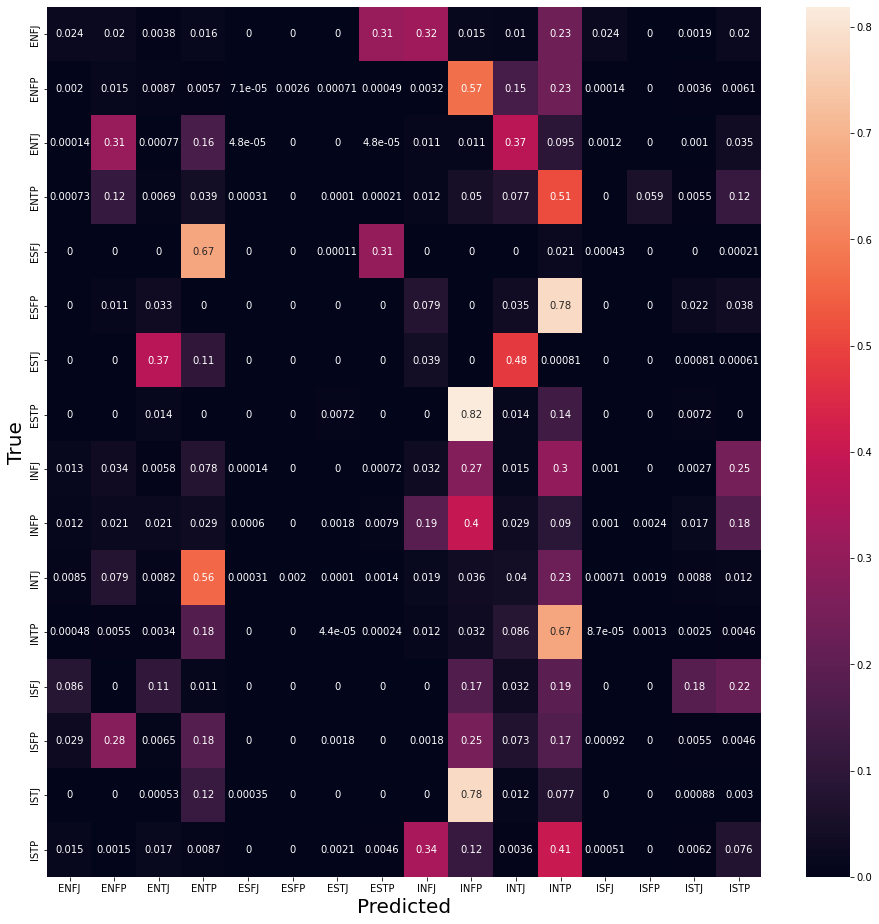

In [46]:
document_multimodel_run('mbti_t5_model',
                         model,
                         predicted_values,
                         actual_classes,
                         actual_values,
                         actual_classes )




# Error Analysis

In [47]:
test_df = test_df[['Username','Age','Posts','Occupation','message','combined']]
test_df.head()

,Username,Age,Posts,Occupation,message,combined
0,fakeplasticalice,39.0,403,None,beats the hell out of me! why the hell woul...,multilabel classification: fakeplasticalice </...
1,julius_van_der_beak,36.0,17582,None,meh. the book seems to have a lot of things...,multilabel classification: julius_van_der_beak...
2,lateralus,47.0,6262,industrial savior,it is also helps that the math is complicate...,multilabel classification: lateralus </s>47.0 ...
3,ransomedbyfire,35.0,172,college student,rolls eyes,multilabel classification: ransomedbyfire </s>...
4,hongdou,27.0,5190,None,"ha ha. well, i have always loved foxes. they...",multilabel classification: hongdou </s>27.0 </...


In [48]:
test_df.shape

(154761, 6)

In [49]:
df2.head()

,predicted,actual
0,ENFP,INFJ
1,INTP,INTP
2,INTJ,ENTJ
3,INFP,ISTJ
4,INTP,ESFJ


In [50]:
test_df['predicted'] = df2['predicted'].to_list()

In [51]:
test_df['label'] = df2['actual'].to_list()

In [52]:
test_df.head()

,Username,Age,Posts,Occupation,message,combined,predicted,label
0,fakeplasticalice,39.0,403,None,beats the hell out of me! why the hell woul...,multilabel classification: fakeplasticalice </...,ENFP,INFJ
1,julius_van_der_beak,36.0,17582,None,meh. the book seems to have a lot of things...,multilabel classification: julius_van_der_beak...,INTP,INTP
2,lateralus,47.0,6262,industrial savior,it is also helps that the math is complicate...,multilabel classification: lateralus </s>47.0 ...,INTJ,ENTJ
3,ransomedbyfire,35.0,172,college student,rolls eyes,multilabel classification: ransomedbyfire </s>...,INFP,ISTJ
4,hongdou,27.0,5190,None,"ha ha. well, i have always loved foxes. they...",multilabel classification: hongdou </s>27.0 </...,INTP,ESFJ


In [53]:
test_df['accurate'] = test_df['label'] == test_df['predicted']
test_df['message_len'] = test_df['message'].str.split().str.len()
test_df['feature_len'] = test_df['combined'].str.split().str.len()

In [54]:
test_df

,Username,Age,Posts,Occupation,message,combined,predicted,label,accurate,message_len,feature_len
0,fakeplasticalice,39.0,403,None,beats the hell out of me! why the hell woul...,multilabel classification: fakeplasticalice </...,ENFP,INFJ,False,21,71
1,julius_van_der_beak,36.0,17582,None,meh. the book seems to have a lot of things...,multilabel classification: julius_van_der_beak...,INTP,INTP,True,232,294
2,lateralus,47.0,6262,industrial savior,it is also helps that the math is complicate...,multilabel classification: lateralus </s>47.0 ...,INTJ,ENTJ,False,33,76
3,ransomedbyfire,35.0,172,college student,rolls eyes,multilabel classification: ransomedbyfire </s>...,INFP,ISTJ,False,2,21
4,hongdou,27.0,5190,None,"ha ha. well, i have always loved foxes. they...",multilabel classification: hongdou </s>27.0 </...,INTP,ESFJ,False,199,255
...,...,...,...,...,...,...,...,...,...,...,...
154756,tallulah,50.0,6009,making sure the world keeps spinning.,yep.,multilabel classification: tallulah </s>50.0 <...,ENTP,INTP,False,1,24
154757,scantilyclad,36.0,2106,manager,lol i am lovin that outfit in the first picture.,multilabel classification: scantilyclad </s>36...,INFP,INFP,True,10,39
154758,wild horses,40.0,1916,car crash waiting to happen,freedom from the ties that bind by guy finlay....,multilabel classification: wild horses </s>40....,INTP,ENFP,False,92,152
154759,julius_van_der_beak,36.0,17582,None,nice work. particularly agree with your extr...,multilabel classification: julius_van_der_beak...,INTP,INTP,True,80,138


/usr/local/lib/python3.8/dist-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


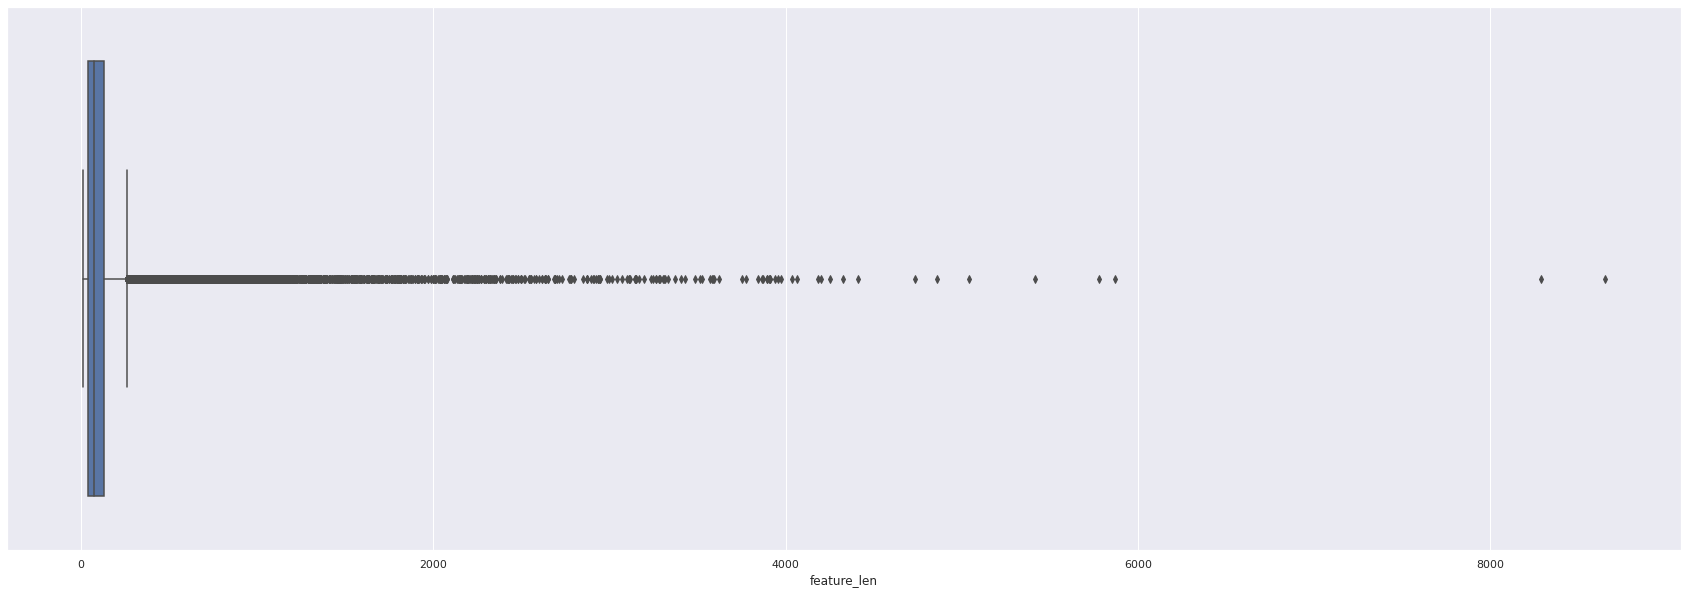

In [55]:
# get feature length distribution and look for outliers

sns.set(rc={'figure.figsize':(30,10)})
sns.boxplot(test_df['feature_len'])

array([<matplotlib.axes._subplots.AxesSubplot object at 0x7fa76f2a4880>,
      dtype=object)

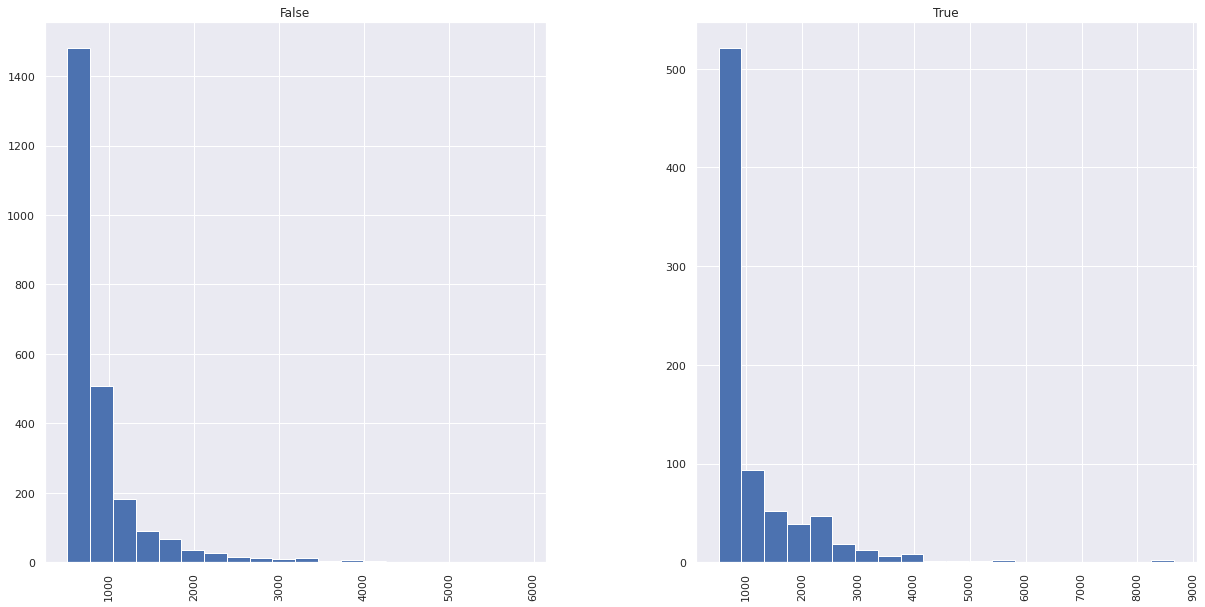

In [56]:
# T5 has a max length of 512, so features longer than that are truncated.  
# has does accuracy compare between truncated and non-truncated features?

test_df['feature_len'][test_df['feature_len'] > 512].hist(by=test_df['accurate'],bins=20,figsize=(20,10))

In [57]:

test_df['accurate'][test_df['feature_len'] > 512].value_counts(normalize = True)

False    0.753
True     0.247
Name: accurate, dtype: float64

In [58]:


test_df['accurate'][test_df['feature_len'] <= 512].value_counts(normalize = True)

False    0.771
True     0.229
Name: accurate, dtype: float64

# Comparing accuracy between truncated and non-truncated samples shows a small accuracy decline when the feature input is truncated.  However, our technique of extracting features and placing them at the beginning of hte feature input preserves information even when inputs are truncated.



Text(0, 0.5, 'Count')

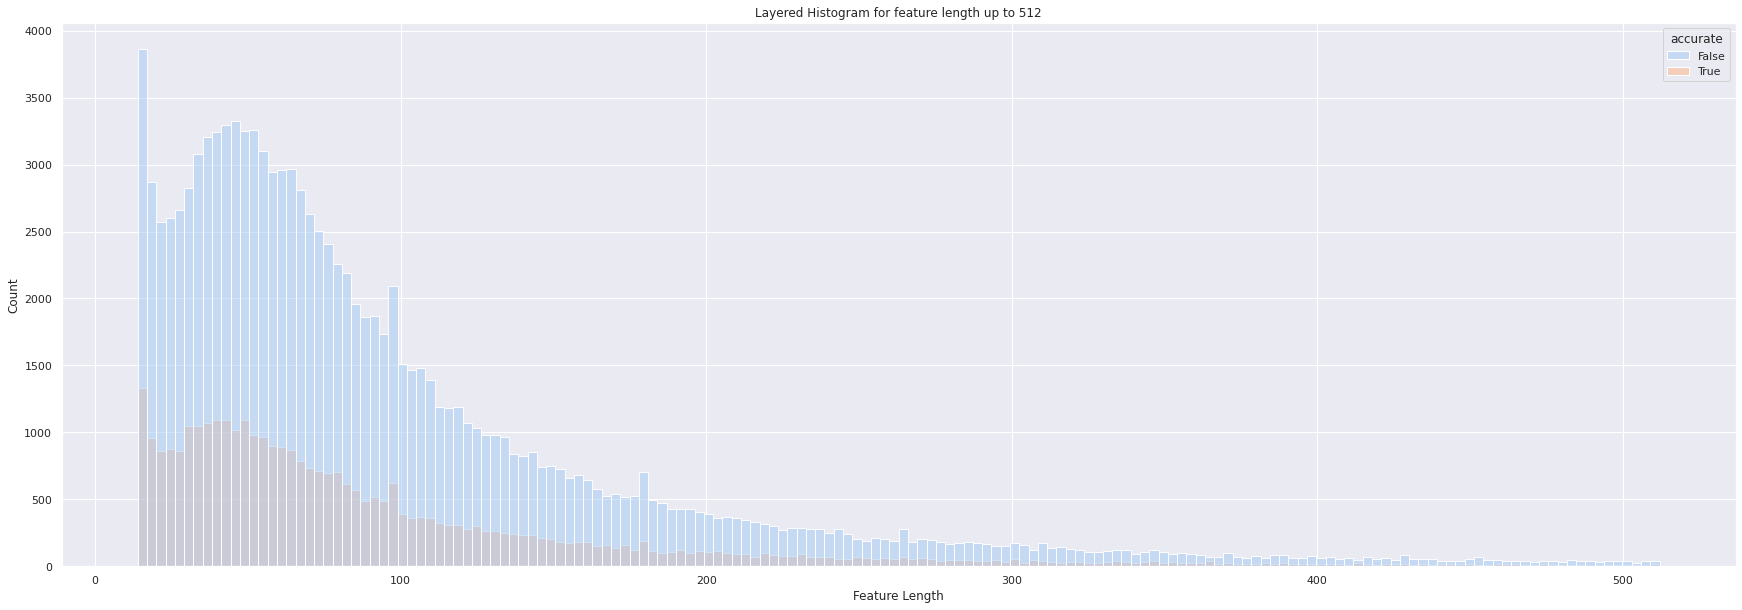

In [59]:

# layered histogram
import matplotlib.pyplot as plt
f = plt.figure(figsize=(30,10))
ax = f.add_subplot(1,1,1)
import seaborn as sns
sns.histplot(data=test_df[test_df['feature_len'] <= 512], ax=ax, stat="count", multiple="layer",
             x="feature_len", kde=False,
             palette="pastel", hue="accurate",
             element="bars", legend=True)
ax.set_title("Layered Histogram for feature length up to 512")
ax.set_xlabel("Feature Length")
ax.set_ylabel("Count")
     

Text(0, 0.5, 'Count')

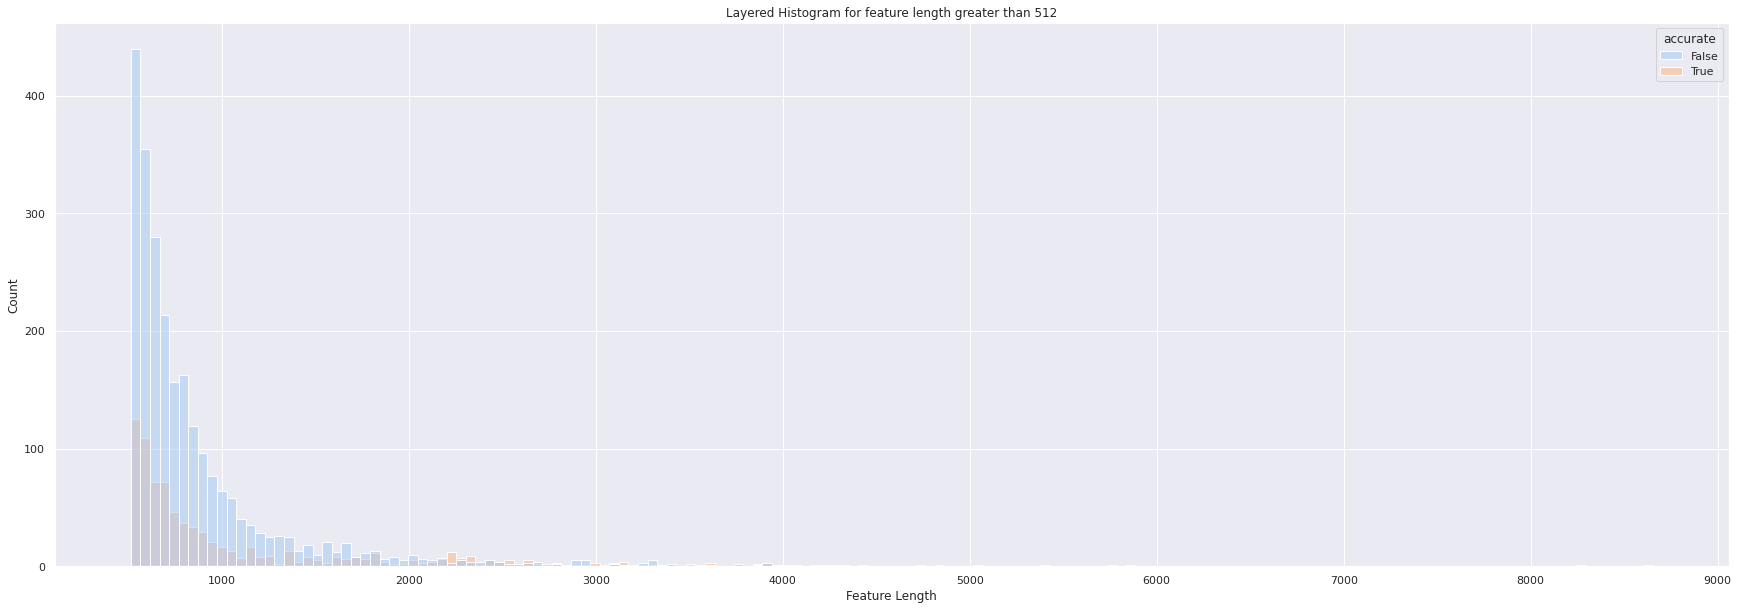

In [60]:

# layered histogram
import matplotlib.pyplot as plt
f = plt.figure(figsize=(30,10))
ax = f.add_subplot(1,1,1)
import seaborn as sns
sns.histplot(data=test_df[test_df['feature_len'] > 512 ], ax=ax, stat="count", multiple="layer",
             x="feature_len", kde=False,
             palette="pastel", hue="accurate",
             element="bars", legend=True)
ax.set_title("Layered Histogram for feature length greater than 512")
ax.set_xlabel("Feature Length")
ax.set_ylabel("Count")
     

# Next, look at relative accuracy across the 16 MBTI categories.


In [61]:
def show_values(axs, orient="v", space=.01):
    def _single(ax):
        if orient == "v":
            for p in ax.patches:
                _x = p.get_x() + p.get_width() / 2
                _y = p.get_y() + p.get_height() + (p.get_height()*0.01)
                value = '{:.0f}'.format(p.get_height())
                ax.text(_x, _y, value, ha="center",fontsize=10) 
        elif orient == "h":
            for p in ax.patches:
                _x = p.get_x() + p.get_width() + float(space)
                _y = p.get_y() + p.get_height() - (p.get_height()*0.5)
                value = '{:.0f}'.format(p.get_width())
                ax.text(_x, _y, value, ha="left",fontsize=10)

    if isinstance(axs, np.ndarray):
        for idx, ax in np.ndenumerate(axs):
            _single(ax)
    else:
        _single(axs)
     

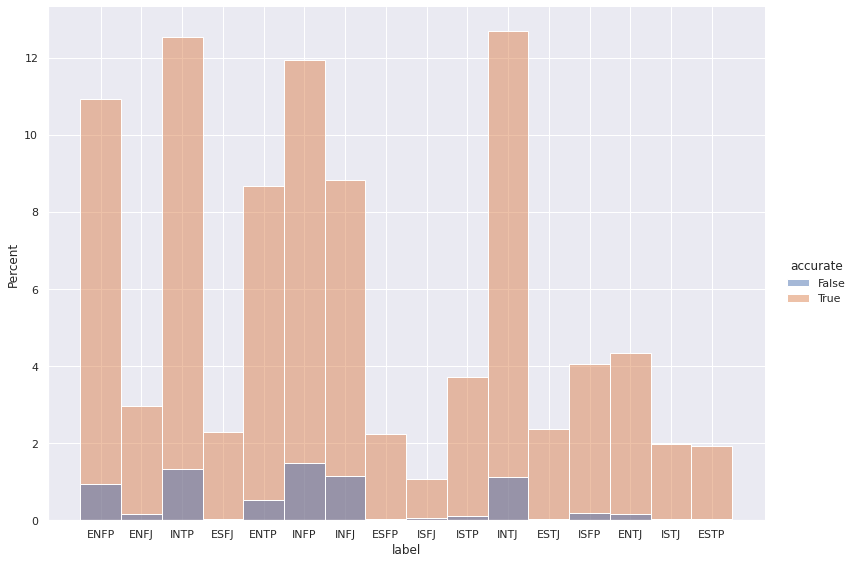

In [ ]:

#let us look at percent distribution of errors per MBTI Type
sns.displot(data=test_df, x='label', stat='percent', hue='accurate',height=8, aspect=11/8)

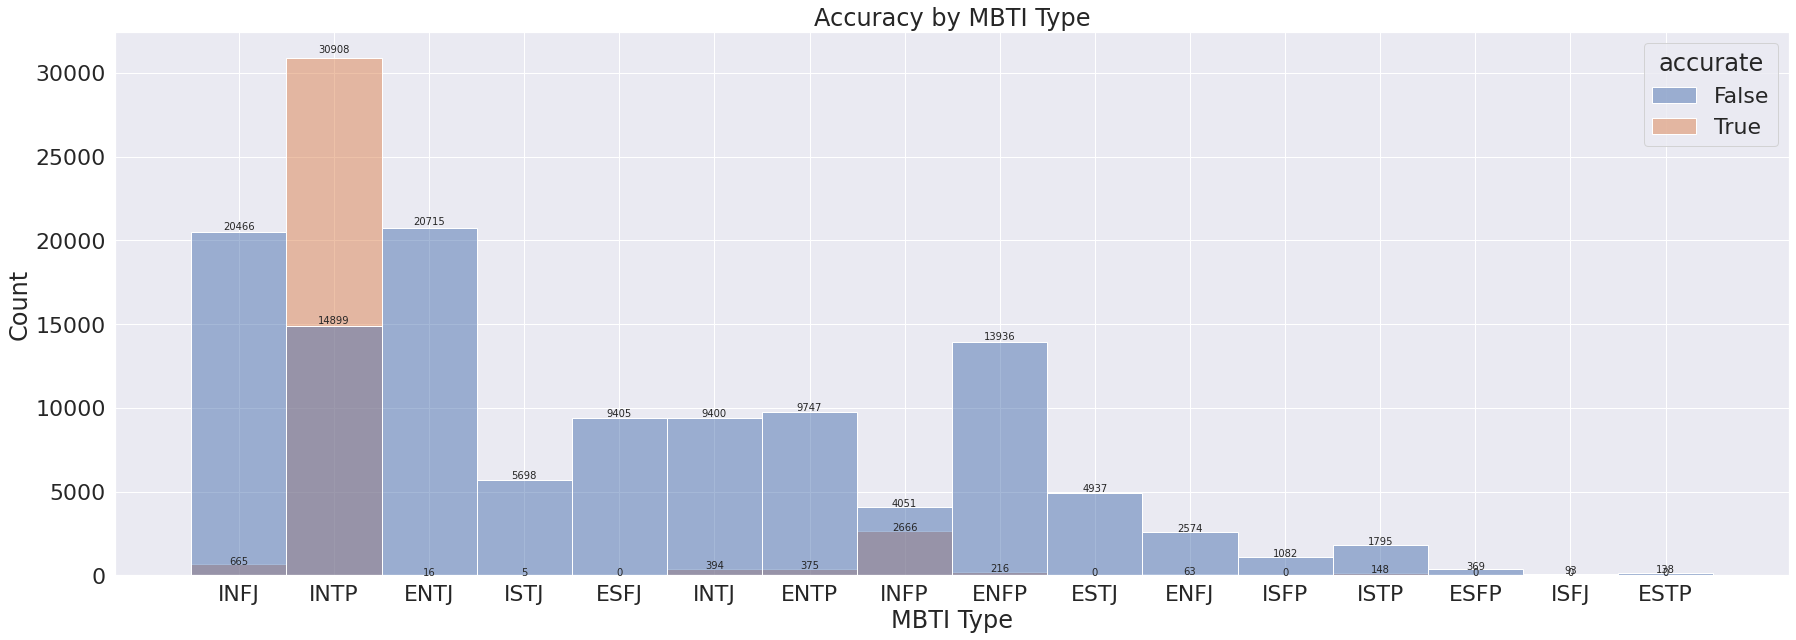

In [62]:

#plot with absolute count
f = plt.figure(figsize=(30,10))
sns.set(font_scale=2)
ax = f.add_subplot(1,1,1)
#sns.histplot(data=add_combined, x="MBTI Type", color="skyblue", label="accurate", kde=True,hue="accurate")
sns.histplot(data=test_df, x="label",  label="accurate", kde=False,hue="accurate")
#sns.histplot(data=add_combined, x="Posts", color="red", label="Posts", kde=True,hue="accurate")
ax.set_title("Accuracy by MBTI Type")
ax.set_xlabel("MBTI Type")
ax.set_ylabel("Count")
show_values(ax)
     

In [ ]:


test_df.groupby(['label'])['accurate'].value_counts(normalize=True).unstack(level=1)

accurate,False,True
label,,
ENFJ,0.054,0.946
ENFP,0.080,0.920
ENTJ,0.036,0.964
ENTP,0.057,0.943
ESFJ,0.014,0.986
ESFP,0.016,0.984
ESTJ,0.012,0.988
ESTP,0.019,0.981
INFJ,0.115,0.885


In [ ]:
top_5_worst = ['INFJ', 'INFP', 'INTP', 'INTJ', 'ENTP']


Text(0, 0.5, 'Count')

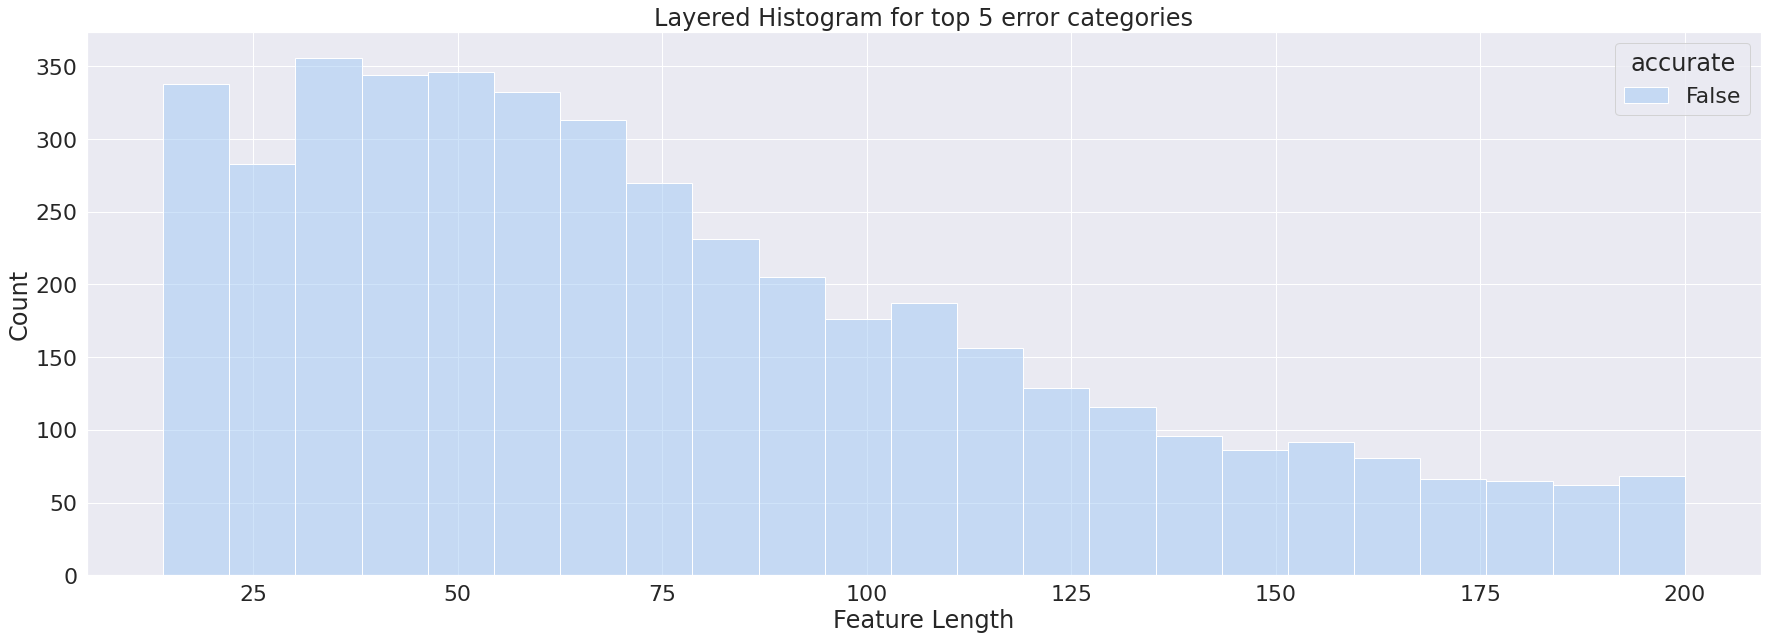

In [ ]:
# layered histogram
import matplotlib.pyplot as plt
f = plt.figure(figsize=(30,10))
ax = f.add_subplot(1,1,1)
import seaborn as sns
sns.histplot(data=test_df[(test_df['label'].isin(top_5_worst)) & (test_df['accurate'] == False) & (test_df['feature_len'] <= 200) ], ax=ax, stat="count", multiple="layer",
             x="feature_len", kde=False,
             palette="pastel", hue="accurate",
             element="bars", legend=True)
ax.set_title("Layered Histogram for top 5 error categories")
ax.set_xlabel("Feature Length")
ax.set_ylabel("Count")
     


In [ ]:

#let us create a error dataframe
drill_down = test_df[(test_df['label'].isin(top_5_worst)) & (test_df['accurate'] == False) & (test_df['feature_len'] <= 200) ]
     


In [ ]:

#analyze occupations
drill_down['Occupation'].value_counts()

student                                                     348
professional artist                                          22
student-geology                                              21
enforcer. i am the law!                                      21
professional gimp, recovering attorney                       20
                                                           ... 
arcade clerk                                                  1
server                                                        1
communications                                                1
again with the jibes. memory loss is a serious condition      1
music student                                                 1
Name: Occupation, Length: 370, dtype: int64

In [ ]:

drill_down['occu_len']=drill_down['Occupation'].str.split().str.len()

<ipython-input-172-b7e9c05b8fe7>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  drill_down['occu_len']=drill_down['Occupation'].str.split().str.len()


Text(0, 0.5, 'Count')

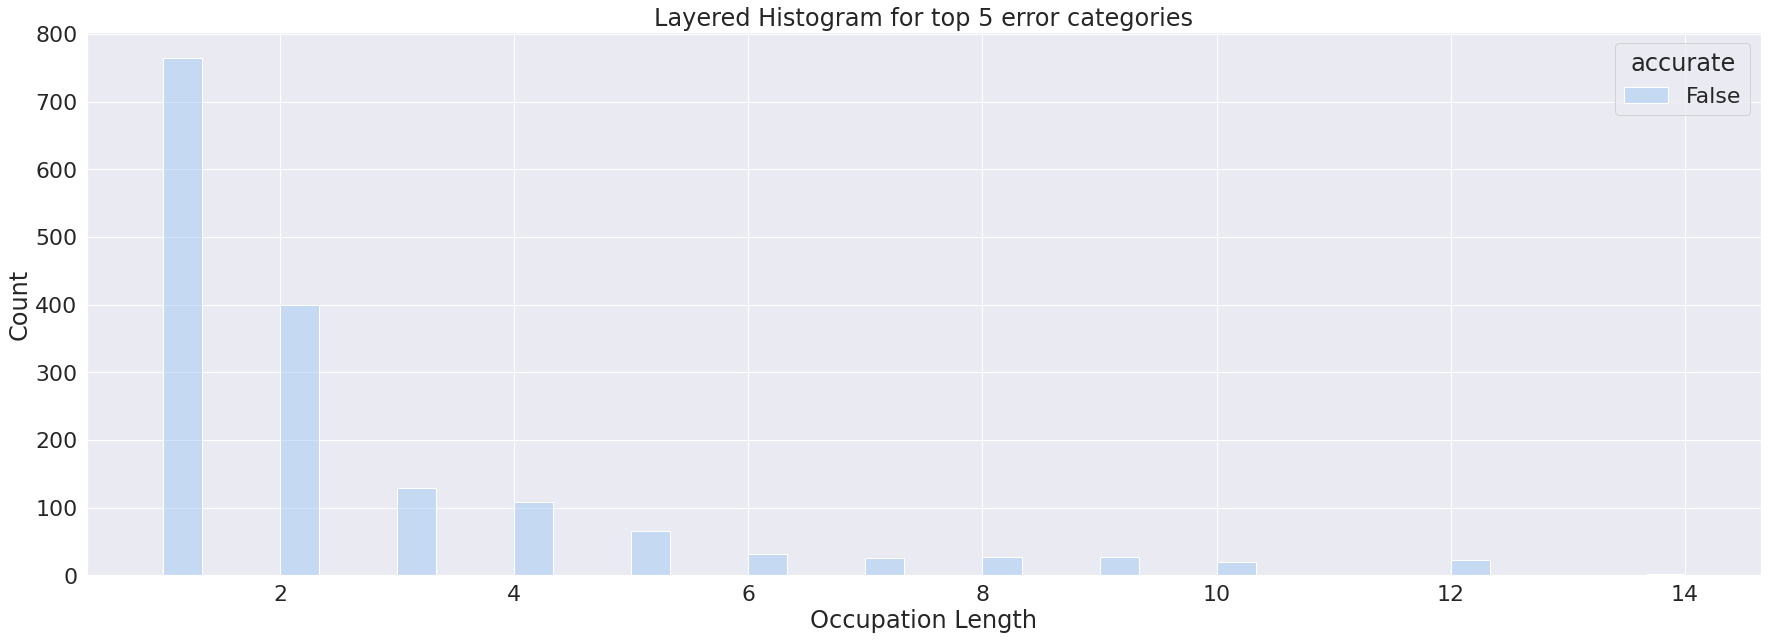

In [ ]:

f = plt.figure(figsize=(30,10))
ax = f.add_subplot(1,1,1)
import seaborn as sns
sns.histplot(data=drill_down, ax=ax, stat="count", multiple="layer",
             x="occu_len", kde=False,
             palette="pastel", hue="accurate",
             element="bars", legend=True)
ax.set_title("Layered Histogram for top 5 error categories")
ax.set_xlabel("Occupation Length")
ax.set_ylabel("Count")

Text(0, 0.5, 'Count')

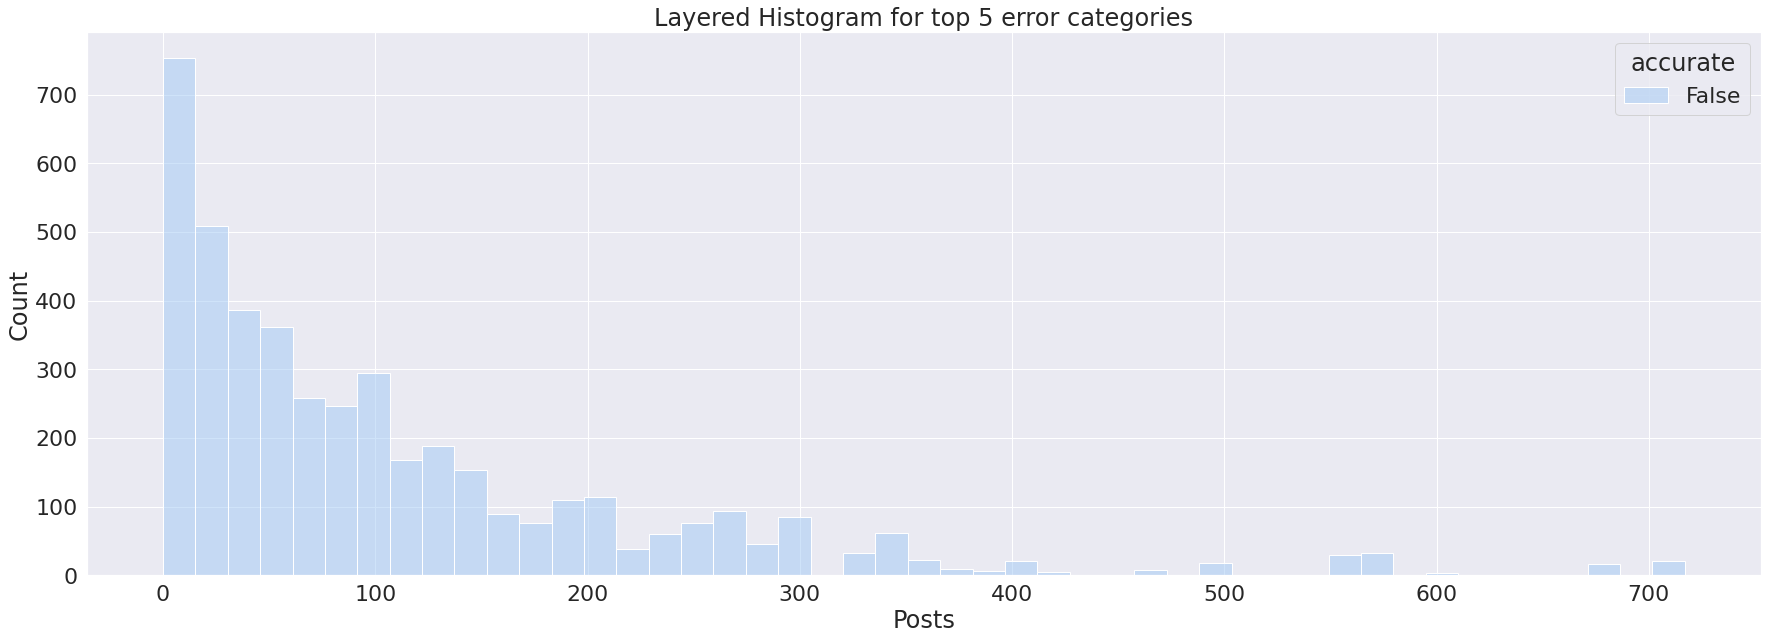

In [ ]:

f = plt.figure(figsize=(30,10))
ax = f.add_subplot(1,1,1)
import seaborn as sns
sns.histplot(data=drill_down, ax=ax, stat="count", multiple="layer",
             x="Posts", kde=False,
             palette="pastel", hue="accurate",
             element="bars", legend=True)
ax.set_title("Layered Histogram for top 5 error categories")
ax.set_xlabel("Posts")
ax.set_ylabel("Count")

## This shows that the T5 model becomes more accurate for people who post more.  The greatest counts of misclassified types are for people with few posts.

In [ ]:
drill_down[drill_down['occu_len']==2]

,Username,Age,Posts,Occupation,message,combined,predicted,label,accurate,message_len,feature_len,occu_len
1400146,evastover,23.0,77,freelance pianist,that is too freudian and slowmoving for my t...,multilabel classification: evastover </s>23.0 ...,ENTP,INFP,False,106,165,2.0
1400159,coll,43.0,73,mental masturbation,turnip farmer,multilabel classification: coll </s>43.0 </s>7...,ENTP,INFJ,False,2,16,2.0
1400400,observer84,38.0,44,lab rat,it is my understanding that there was no sex...,multilabel classification: observer84 </s>38.0...,ENFP,INTP,False,38,87,2.0
1400433,talisyn,38.0,84,elementary teacher,why? because he was actually never born.,multilabel classification: talisyn </s>38.0 </...,INFJ,INFP,False,7,31,2.0
1400550,sqnh,42.0,28,graduate student,someone get banned so i can read the banned an...,multilabel classification: sqnh </s>42.0 </s>2...,ISTJ,INFP,False,12,40,2.0
...,...,...,...,...,...,...,...,...,...,...,...,...
1492326,peter pettishrooms,29.0,59,professional freeloader,cool thanks. glad to hear it. i actually wou...,multilabel classification: peter pettishrooms ...,ENFP,INTJ,False,29,73,2.0
1492387,moonlit_reveries,37.0,26,music student,hehe thanks for the welcome czecze. i hope to ...,multilabel classification: moonlit_reveries </...,ENFP,INFJ,False,14,58,2.0
1492515,snail,43.0,141,"artist, songwriter/performer",i like your writing as is. it could be a co...,multilabel classification: snail </s>43.0 </s>...,ISTJ,INFP,False,38,75,2.0
1492612,abhaya,38.0,97,tile setter/musician/artist,hello :hi:,multilabel classification: abhaya </s>38.0 </s...,ISTJ,INFP,False,2,18,2.0


Text(0, 0.5, 'Count')

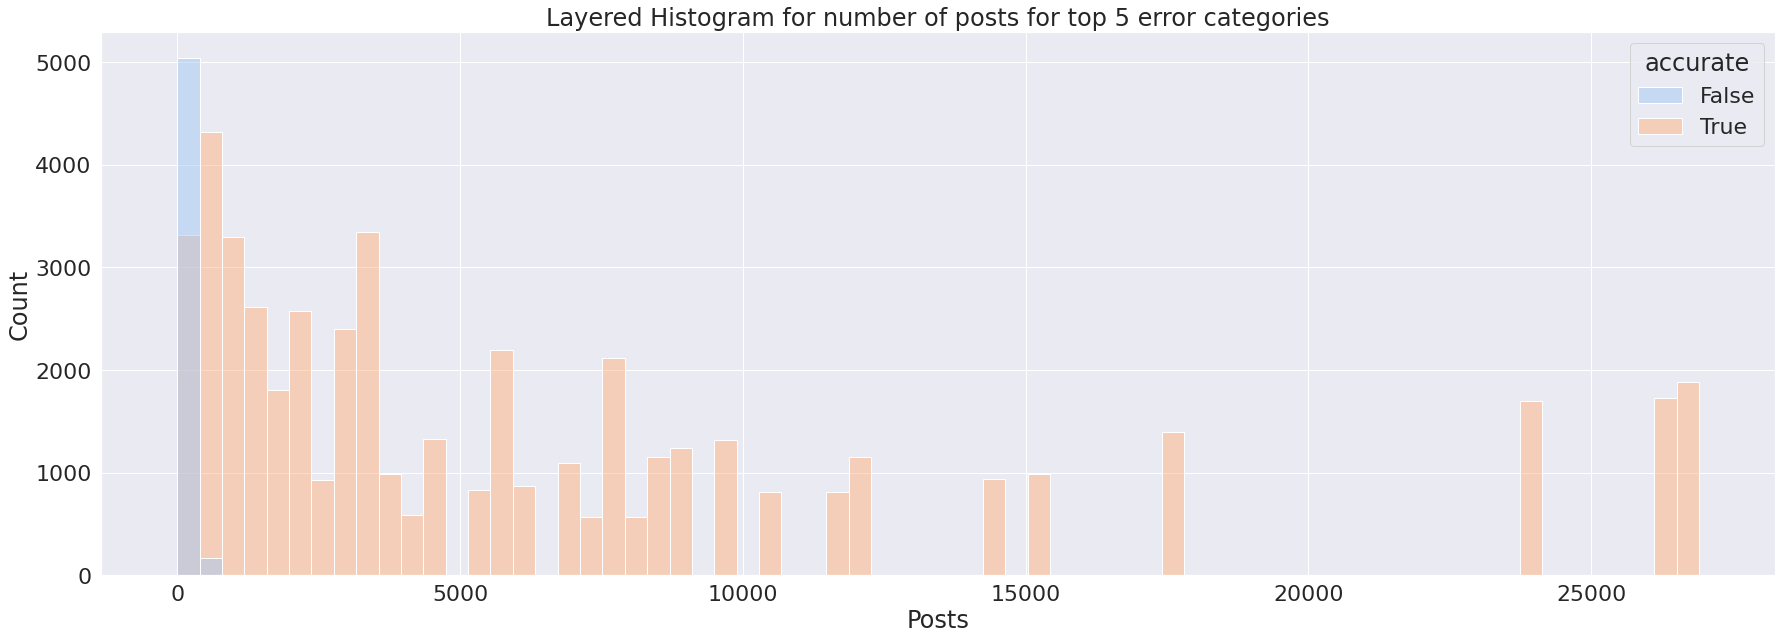

In [ ]:

# layered histogram
import matplotlib.pyplot as plt
f = plt.figure(figsize=(30,10))
ax = f.add_subplot(1,1,1)
import seaborn as sns
sns.histplot(data=test_df[test_df['label'].isin(top_5_worst)], ax=ax, stat="count", multiple="layer",
             x="Posts", kde=False,
             palette="pastel", hue="accurate",
             element="bars", legend=True)
ax.set_title("Layered Histogram for number of posts for top 5 error categories")
ax.set_xlabel("Posts")
ax.set_ylabel("Count")

## This plot shows again that we are prone to misclassifcation for users with few posts.